# **Importing Important Libraries**

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch
import torch.nn as nn
from torch.autograd import Variable
import random
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

### If the GPU is available use it for the computation otherwise use the CPU.

In [77]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 2. Using FashionMNIST class from torchvision module.


*   It will download the dataset first time.




In [78]:

train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  
                                          

In [79]:

train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)
                                      

### We have 10 types of clothes in FashionMNIST dataset.


> Making a method that return the name of class for the label number.
ex. if the label is 5, we return Sandal.



In [80]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

### Playing with data and displaying some images using matplotlib imshow() method.





In [81]:
a = next(iter(train_loader))
a[0].size()

torch.Size([100, 1, 28, 28])

In [82]:
len(train_set)

60000

9


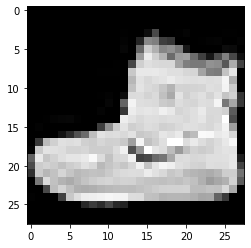

In [83]:
#show the image to check 
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [84]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

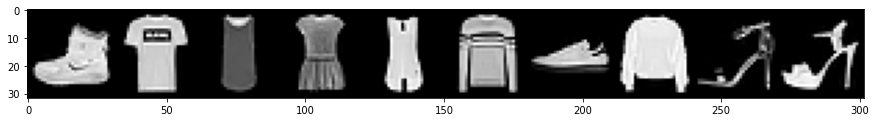

In [85]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")


In [86]:
model_comparision={}



## First Simple Conv2d Model

### Hyperparameter for this model Learning Rate (0.0001,0.001,0.01)

### Learning Rate 0.0001

In [87]:
class CNN1(nn.Module):
    
    def __init__(self):
        super(CNN1, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
            nn.ReLU(),  
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
        )
        
        
        self.fc1 = nn.Linear(in_features=64*22*22, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [88]:
model = CNN1()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

CNN1(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (fc1): Linear(in_features=30976, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [89]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in tqdm(train_loader):
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

 84%|████████▎ | 501/600 [01:27<01:07,  1.47it/s]

Iteration: 500, Loss: 0.5909267067909241, Accuracy: 80.52999877929688%


 67%|██████▋   | 401/600 [01:08<02:17,  1.44it/s]

Iteration: 1000, Loss: 0.4341971278190613, Accuracy: 83.86000061035156%


 50%|█████     | 301/600 [00:52<03:26,  1.45it/s]

Iteration: 1500, Loss: 0.3364342451095581, Accuracy: 84.97000122070312%


 34%|███▎      | 202/600 [00:34<03:25,  1.94it/s]

Iteration: 2000, Loss: 0.3458821475505829, Accuracy: 86.44999694824219%


 17%|█▋        | 101/600 [00:17<05:45,  1.44it/s]

Iteration: 2500, Loss: 0.3091624975204468, Accuracy: 87.73999786376953%


100%|██████████| 600/600 [01:45<00:00,  5.71it/s]

Iteration: 3000, Loss: 0.23623162508010864, Accuracy: 87.83999633789062%


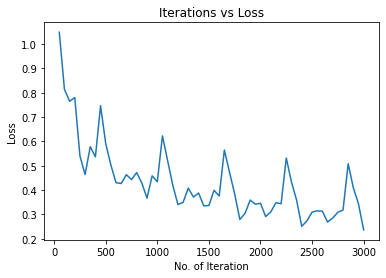

In [90]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

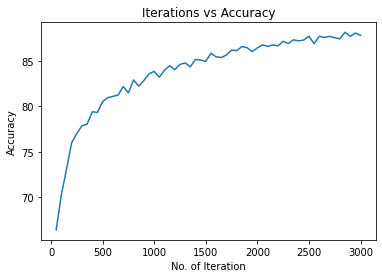

In [91]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [92]:
model_comparision['CNN1']=int(sum(accuracy_list) / len(accuracy_list))

### Learning Rate 0.001

In [93]:
class CNN2(nn.Module):
    
    def __init__(self):
        super(CNN2, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
            nn.ReLU(),  
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
        )
        
        
        self.fc1 = nn.Linear(in_features=64*22*22, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [94]:
model = CNN2()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

CNN2(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (fc1): Linear(in_features=30976, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [95]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in tqdm(train_loader):
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

 84%|████████▎ | 501/600 [01:27<01:09,  1.42it/s]

Iteration: 500, Loss: 0.43255409598350525, Accuracy: 87.77999877929688%


 67%|██████▋   | 402/600 [01:08<01:59,  1.65it/s]

Iteration: 1000, Loss: 0.2868185341358185, Accuracy: 89.87999725341797%


 50%|█████     | 301/600 [00:58<03:27,  1.44it/s]

Iteration: 1500, Loss: 0.28892552852630615, Accuracy: 89.41999816894531%


 34%|███▎      | 202/600 [00:35<03:52,  1.71it/s]

Iteration: 2000, Loss: 0.13865430653095245, Accuracy: 90.5999984741211%


 17%|█▋        | 102/600 [00:17<04:12,  1.97it/s]

Iteration: 2500, Loss: 0.13130885362625122, Accuracy: 89.87999725341797%


100%|██████████| 600/600 [01:45<00:00,  5.70it/s]

Iteration: 3000, Loss: 0.15432588756084442, Accuracy: 90.19000244140625%


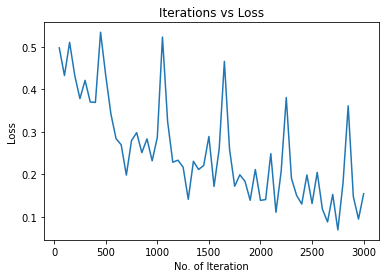

In [96]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

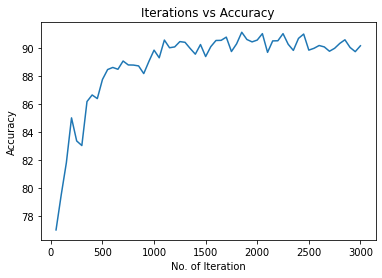

In [97]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [98]:
model_comparision['CNN2']=int(sum(accuracy_list) / len(accuracy_list))

### Learning Rate 0.01

In [99]:
class CNN3(nn.Module):
    
    def __init__(self):
        super(CNN3, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
            nn.ReLU(),  
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
        )
        
        
        self.fc1 = nn.Linear(in_features=64*22*22, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [100]:
model = CNN3()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

CNN3(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (fc1): Linear(in_features=30976, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [101]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in tqdm(train_loader):
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

 84%|████████▎ | 502/600 [01:28<00:50,  1.95it/s]

Iteration: 500, Loss: 0.5299394130706787, Accuracy: 84.12000274658203%


 67%|██████▋   | 402/600 [01:13<02:25,  1.36it/s]

Iteration: 1000, Loss: 0.350043386220932, Accuracy: 85.97000122070312%


 50%|█████     | 301/600 [00:56<03:57,  1.26it/s]

Iteration: 1500, Loss: 0.39765799045562744, Accuracy: 85.33999633789062%


 34%|███▎      | 201/600 [00:37<04:48,  1.38it/s]

Iteration: 2000, Loss: 0.3764595687389374, Accuracy: 86.48999786376953%


 17%|█▋        | 102/600 [00:19<05:38,  1.47it/s]

Iteration: 2500, Loss: 0.31717419624328613, Accuracy: 87.02999877929688%


100%|██████████| 600/600 [01:52<00:00,  5.32it/s]

Iteration: 3000, Loss: 0.33662402629852295, Accuracy: 86.0199966430664%


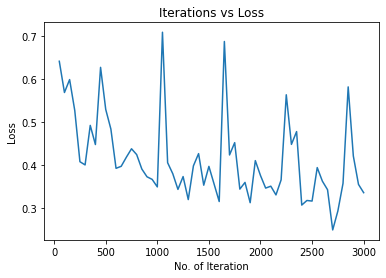

In [102]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

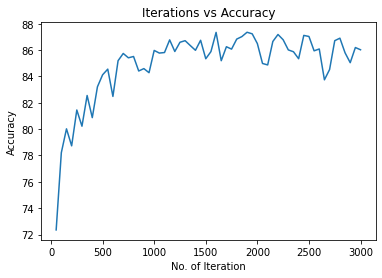

In [103]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [104]:
model_comparision['CNN3']=int(sum(accuracy_list) / len(accuracy_list))

In [105]:
model_comparision

{'CNN1': 83, 'CNN2': 88, 'CNN3': 84}

## Second Conv2d Model

*   Make a model class (FashionCNN in our case)
    * It inherit nn.Module class that is a super class for all the neural networks in Pytorch.

     




## Neural Net
* Our Neural Net has following layers:
    * Two Sequential layers each consists of following layers-
        * Convolution layer that has kernel size of 3 * 3, padding = 1 (zero_padding) in 1st layer and padding = 0 in second one. Stride of 1 in both layer.
        * Acitvation function: ReLU.
        * Max Pooling layer with kernel size of 2 * 2 and stride 2.
     * Flatten out the output for dense layer(a.k.a. fully connected layer).
     * 3 Fully connected layer  with different in/out features.
     * 1 Dropout layer that has class probability p = 0.25.
  
     * All the functionaltiy is given in forward method that defines the forward pass of CNN.
     * Our input image is changing in a following way:

### Hyperparameter for this model are add DropOut layers and Maxpooling layers and Batchsize

As we know that dropout layer helping to avoid overfitting the model and maxplooing layers add reduce the dimention of layers

#### Add Maxpoling layers with batchsize 32

In [106]:
batch_size = 32
keep_prob = 1

In [107]:
class CNN4(torch.nn.Module):

    def __init__(self):
        super(CNN4, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))
        
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) 

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out


#instantiate CNN model
model = CNN4()
model

<ipython-input-107-60c387c42d0b>:19: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


CNN4(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2048, out_features=625, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=2048, out_features=625, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=625, out_features=10, bias=True)
)

In [108]:
learning_rate = 0.0001
criterion = torch.nn.CrossEntropyLoss()    # Softmax is internally computed.
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)


In [109]:
print('Training the Deep Learning network ...')
train_cost = []
train_accu = []
test_accu= []

training_epochs = 5
total_batch = len(train_set) // batch_size

print('Size of the training dataset is {}'.format(train_set.data.size()))
print('Size of the testing dataset'.format(test_set.data.size()))
print('Batch size is : {}'.format(batch_size))
print('Total number of batches is : {0:2.0f}'.format(total_batch))
print('\nTotal number of epochs is : {0:2.0f}'.format(training_epochs))
X_test = Variable(test_set.data.view(len(test_set), 1, 28, 28).float())
Y_test = Variable(test_set.targets)

for epoch in range(training_epochs):
    avg_cost = 0
    for i, (batch_X, batch_Y) in enumerate(train_loader):
        X = Variable(batch_X)    # image is already size of (28x28), no reshape
        Y = Variable(batch_Y)    # label is not one-hot encoded

        optimizer.zero_grad() # <= initialization of the gradients
        
        # forward propagation
        hypothesis = model(X)
        cost = criterion(hypothesis, Y) # <= compute the loss function
        
        # Backward propagation
        cost.backward() # <= compute the gradient of the loss/cost function     
        optimizer.step() # <= Update the gradients
             
        # Print some performance to monitor the training
        prediction = hypothesis.data.max(dim=1)[1]
        train_accu.append(((prediction.data == Y.data).float().mean()).item())
        train_cost.append(cost.item())   
        if i % 200 == 0:
            print("Epoch= {},\t batch = {},\t cost = {:2.4f},\t accuracy = {}".format(epoch+1, i, train_cost[-1], train_accu[-1]))
       
        avg_cost += cost.data / total_batch

    test_prediction = model(X_test)
        # Compute test accuracy
    correct_prediction = (torch.max(test_prediction.data, dim=1)[1] == Y_test.data)
    test_accuracy = correct_prediction.float().mean().item() 
    test_accu.append(test_accuracy)

        

    print("[Epoch: {:>4}], averaged cost = {:>.9}".format(epoch + 1, avg_cost.item()))
    print("[Epoch: {:>4}], test = {:>.9}".format(epoch + 1, test_accuracy))




print('Learning Finished!')

Training the Deep Learning network ...
Size of the training dataset is torch.Size([60000, 28, 28])
Size of the testing dataset
Batch size is : 32
Total number of batches is : 1875

Total number of epochs is :  5
Epoch= 1,	 batch = 0,	 cost = 2.2942,	 accuracy = 0.10999999940395355
Epoch= 1,	 batch = 200,	 cost = 0.5534,	 accuracy = 0.8199999928474426
Epoch= 1,	 batch = 400,	 cost = 0.5252,	 accuracy = 0.8199999928474426
[Epoch:    1], averaged cost = 0.213137463
[Epoch:    1], test = 0.78549999
Epoch= 2,	 batch = 0,	 cost = 0.3084,	 accuracy = 0.9200000166893005
Epoch= 2,	 batch = 200,	 cost = 0.3287,	 accuracy = 0.8600000143051147
Epoch= 2,	 batch = 400,	 cost = 0.5063,	 accuracy = 0.8199999928474426
[Epoch:    2], averaged cost = 0.131127492
[Epoch:    2], test = 0.810000002
Epoch= 3,	 batch = 0,	 cost = 0.2455,	 accuracy = 0.8999999761581421
Epoch= 3,	 batch = 200,	 cost = 0.2937,	 accuracy = 0.8799999952316284
Epoch= 3,	 batch = 400,	 cost = 0.4916,	 accuracy = 0.8399999737739563
[

(<AxesSubplot:>, [<matplotlib.lines.Line2D at 0x7f34dfca60d0>], (0.0, 100.0))

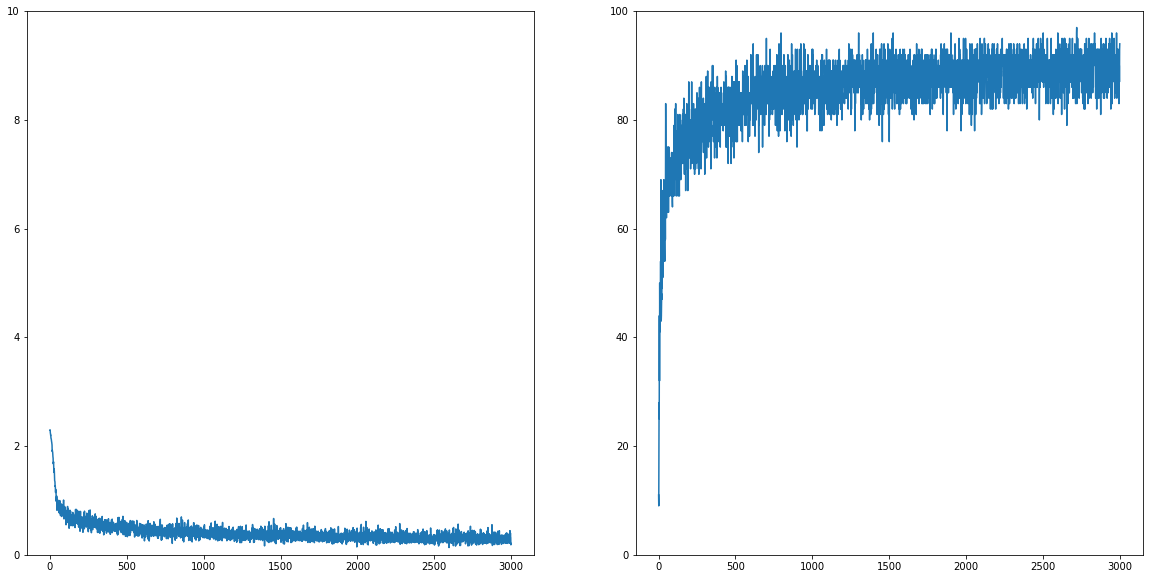

In [110]:
from matplotlib import pylab as plt
import numpy as np
plt.figure(figsize=(20,10))
plt.subplot(121), plt.plot(np.arange(len(train_cost)), train_cost), plt.ylim([0,10])
plt.subplot(122), plt.plot(np.arange(len(train_accu)), 100 * torch.as_tensor(train_accu).numpy()), plt.ylim([0,100])

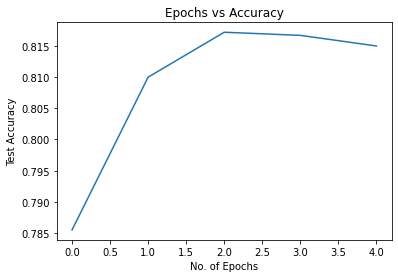

In [111]:
plt.plot(range(training_epochs), test_accu)
plt.xlabel("No. of Epochs")
plt.ylabel("Test Accuracy")
plt.title("Epochs vs Accuracy")
plt.show()

In [112]:
# Test model and check accuracy
model.eval()    # set the model to evaluation mode (dropout=False)

X_test = Variable(test_set.data.view(len(test_set), 1, 28, 28).float())
Y_test = Variable(test_set.targets)

prediction = model(X_test)

# Compute accuracy
correct_prediction = (torch.max(prediction.data, dim=1)[1] == Y_test.data)
accuracy = correct_prediction.float().mean().item()
print('\nAccuracy: {:2.2f} %'.format(accuracy*100))


Accuracy: 81.50 %


In [113]:
model_comparision['CNN4']=int(sum(test_accu*100) / len(test_accu))

#### Add Maxpoling layers with batchsize 64

In [114]:
batch_size = 64


In [115]:
class CNN5(torch.nn.Module):

    def __init__(self):
        super(CNN5, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(p=1 - keep_prob))
        
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out


#instantiate CNN model
model = CNN5()
model

<ipython-input-115-177eade2f235>:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


CNN5(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=2048, out_features=625, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=2048, out_features=625, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=625, out_features=10, bias=True)
)

In [116]:
learning_rate = 0.0001
criterion = torch.nn.CrossEntropyLoss()    # Softmax is internally computed.
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)


In [117]:
print('Training the Deep Learning network ...')
train_cost = []
train_accu = []
test_accu= []

training_epochs = 5
total_batch = len(train_set) // batch_size

print('Size of the training dataset is {}'.format(train_set.data.size()))
print('Size of the testing dataset'.format(test_set.data.size()))
print('Batch size is : {}'.format(batch_size))
print('Total number of batches is : {0:2.0f}'.format(total_batch))
print('\nTotal number of epochs is : {0:2.0f}'.format(training_epochs))
X_test = Variable(test_set.data.view(len(test_set), 1, 28, 28).float())
Y_test = Variable(test_set.targets)

for epoch in range(training_epochs):
    avg_cost = 0
    for i, (batch_X, batch_Y) in enumerate(train_loader):
        X = Variable(batch_X)    # image is already size of (28x28), no reshape
        Y = Variable(batch_Y)    # label is not one-hot encoded

        optimizer.zero_grad() # <= initialization of the gradients
        
        # forward propagation
        hypothesis = model(X)
        cost = criterion(hypothesis, Y) # <= compute the loss function
        
        # Backward propagation
        cost.backward() # <= compute the gradient of the loss/cost function     
        optimizer.step() # <= Update the gradients
             
        # Print some performance to monitor the training
        prediction = hypothesis.data.max(dim=1)[1]
        train_accu.append(((prediction.data == Y.data).float().mean()).item())
        train_cost.append(cost.item())   
        if i % 200 == 0:
            print("Epoch= {},\t batch = {},\t cost = {:2.4f},\t accuracy = {}".format(epoch+1, i, train_cost[-1], train_accu[-1]))
       
        avg_cost += cost.data / total_batch

    test_prediction = model(X_test)
        # Compute test accuracy
    correct_prediction = (torch.max(test_prediction.data, dim=1)[1] == Y_test.data)
    test_accuracy = correct_prediction.float().mean().item() 
    test_accu.append(test_accuracy)

        

    print("[Epoch: {:>4}], averaged cost = {:>.9}".format(epoch + 1, avg_cost.item()))
    print("[Epoch: {:>4}], test = {:>.9}".format(epoch + 1, test_accuracy))




print('Learning Finished!')

Training the Deep Learning network ...
Size of the training dataset is torch.Size([60000, 28, 28])
Size of the testing dataset
Batch size is : 64
Total number of batches is : 937

Total number of epochs is :  5
Epoch= 1,	 batch = 0,	 cost = 2.3082,	 accuracy = 0.07000000029802322
Epoch= 1,	 batch = 200,	 cost = 0.5699,	 accuracy = 0.8100000023841858
Epoch= 1,	 batch = 400,	 cost = 0.5386,	 accuracy = 0.800000011920929
[Epoch:    1], averaged cost = 0.441130757
[Epoch:    1], test = 0.693300009
Epoch= 2,	 batch = 0,	 cost = 0.3144,	 accuracy = 0.9100000262260437
Epoch= 2,	 batch = 200,	 cost = 0.3223,	 accuracy = 0.8700000047683716
Epoch= 2,	 batch = 400,	 cost = 0.5184,	 accuracy = 0.8100000023841858
[Epoch:    2], averaged cost = 0.265760154
[Epoch:    2], test = 0.734399974
Epoch= 3,	 batch = 0,	 cost = 0.2498,	 accuracy = 0.8999999761581421
Epoch= 3,	 batch = 200,	 cost = 0.2912,	 accuracy = 0.8700000047683716
Epoch= 3,	 batch = 400,	 cost = 0.5123,	 accuracy = 0.8100000023841858
[E

(<AxesSubplot:>, [<matplotlib.lines.Line2D at 0x7f34e409a5b0>], (0.0, 100.0))

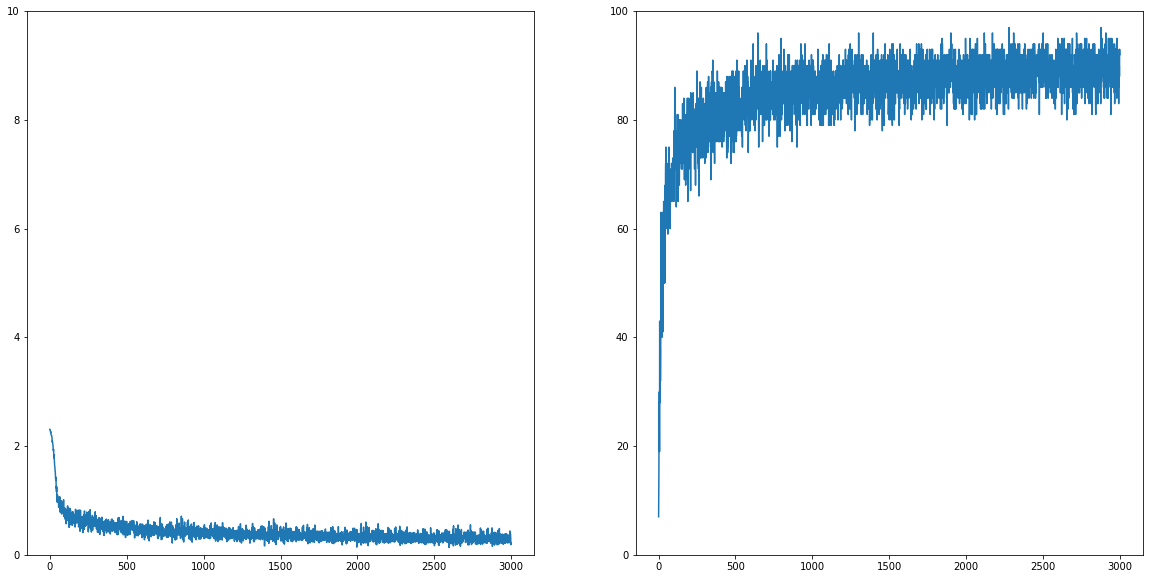

In [118]:
from matplotlib import pylab as plt
import numpy as np
plt.figure(figsize=(20,10))
plt.subplot(121), plt.plot(np.arange(len(train_cost)), train_cost), plt.ylim([0,10])
plt.subplot(122), plt.plot(np.arange(len(train_accu)), 100 * torch.as_tensor(train_accu).numpy()), plt.ylim([0,100])

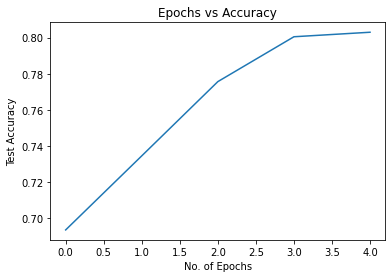

In [119]:
plt.plot(range(training_epochs), test_accu)
plt.xlabel("No. of Epochs")
plt.ylabel("Test Accuracy")
plt.title("Epochs vs Accuracy")
plt.show()

In [120]:
# Test model and check accuracy
model.eval()    # set the model to evaluation mode (dropout=False)

X_test = Variable(test_set.data.view(len(test_set), 1, 28, 28).float())
Y_test = Variable(test_set.targets)

prediction = model(X_test)

# Compute accuracy
correct_prediction = (torch.max(prediction.data, dim=1)[1] == Y_test.data)
accuracy = correct_prediction.float().mean().item()
print('\nAccuracy: {:2.2f} %'.format(accuracy*100))


Accuracy: 80.30 %


In [121]:
model_comparision['CNN5']=int(sum(test_accu*100) / len(test_accu))

In [122]:
model_comparision

{'CNN1': 83, 'CNN2': 88, 'CNN3': 84, 'CNN4': 80, 'CNN5': 76}

#### Add Maxpoling layers with batchsize 128

In [123]:
batch_size = 128

In [124]:
class CNN6(torch.nn.Module):

    def __init__(self):
        super(CNN6, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(p=1 - keep_prob))
        
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out


#instantiate CNN model
model = CNN6()
model

<ipython-input-124-f2d179549b09>:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


CNN6(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=2048, out_features=625, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=2048, out_features=625, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=625, out_features=10, bias=True)
)

In [125]:
# learning rate 
learning_rate = 0.0001
criterion = torch.nn.CrossEntropyLoss()    # Softmax is internally computed.
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)


In [126]:
print('Training the Deep Learning network ...')
train_cost = []
train_accu = []
test_accu= []

training_epochs = 5
total_batch = len(train_set) // batch_size

print('Size of the training dataset is {}'.format(train_set.data.size()))
print('Size of the testing dataset'.format(test_set.data.size()))
print('Batch size is : {}'.format(batch_size))
print('Total number of batches is : {0:2.0f}'.format(total_batch))
print('\nTotal number of epochs is : {0:2.0f}'.format(training_epochs))
X_test = Variable(test_set.data.view(len(test_set), 1, 28, 28).float())
Y_test = Variable(test_set.targets)

for epoch in range(training_epochs):
    avg_cost = 0
    for i, (batch_X, batch_Y) in enumerate(train_loader):
        X = Variable(batch_X)    # image is already size of (28x28), no reshape
        Y = Variable(batch_Y)    # label is not one-hot encoded

        optimizer.zero_grad() # <= initialization of the gradients
        
        # forward propagation
        hypothesis = model(X)
        cost = criterion(hypothesis, Y) # <= compute the loss function
        
        # Backward propagation
        cost.backward() # <= compute the gradient of the loss/cost function     
        optimizer.step() # <= Update the gradients
             
        # Print some performance to monitor the training
        prediction = hypothesis.data.max(dim=1)[1]
        train_accu.append(((prediction.data == Y.data).float().mean()).item())
        train_cost.append(cost.item())   
        if i % 200 == 0:
            print("Epoch= {},\t batch = {},\t cost = {:2.4f},\t accuracy = {}".format(epoch+1, i, train_cost[-1], train_accu[-1]))
       
        avg_cost += cost.data / total_batch

    test_prediction = model(X_test)
        # Compute test accuracy
    correct_prediction = (torch.max(test_prediction.data, dim=1)[1] == Y_test.data)
    test_accuracy = correct_prediction.float().mean().item() 
    test_accu.append(test_accuracy)

        

    print("[Epoch: {:>4}], averaged cost = {:>.9}".format(epoch + 1, avg_cost.item()))
    print("[Epoch: {:>4}], test = {:>.9}".format(epoch + 1, test_accuracy))




print('Learning Finished!')

Training the Deep Learning network ...
Size of the training dataset is torch.Size([60000, 28, 28])
Size of the testing dataset
Batch size is : 128
Total number of batches is : 468

Total number of epochs is :  5
Epoch= 1,	 batch = 0,	 cost = 2.3097,	 accuracy = 0.03999999910593033
Epoch= 1,	 batch = 200,	 cost = 0.5744,	 accuracy = 0.8199999928474426
Epoch= 1,	 batch = 400,	 cost = 0.5149,	 accuracy = 0.8199999928474426
[Epoch:    1], averaged cost = 0.870110154
[Epoch:    1], test = 0.768700004
Epoch= 2,	 batch = 0,	 cost = 0.2999,	 accuracy = 0.9100000262260437
Epoch= 2,	 batch = 200,	 cost = 0.3190,	 accuracy = 0.8799999952316284
Epoch= 2,	 batch = 400,	 cost = 0.4943,	 accuracy = 0.8199999928474426
[Epoch:    2], averaged cost = 0.522998035
[Epoch:    2], test = 0.790700018
Epoch= 3,	 batch = 0,	 cost = 0.2386,	 accuracy = 0.8899999856948853
Epoch= 3,	 batch = 200,	 cost = 0.2894,	 accuracy = 0.8600000143051147
Epoch= 3,	 batch = 400,	 cost = 0.5023,	 accuracy = 0.8500000238418579


(<AxesSubplot:>, [<matplotlib.lines.Line2D at 0x7f34afff0ee0>], (0.0, 100.0))

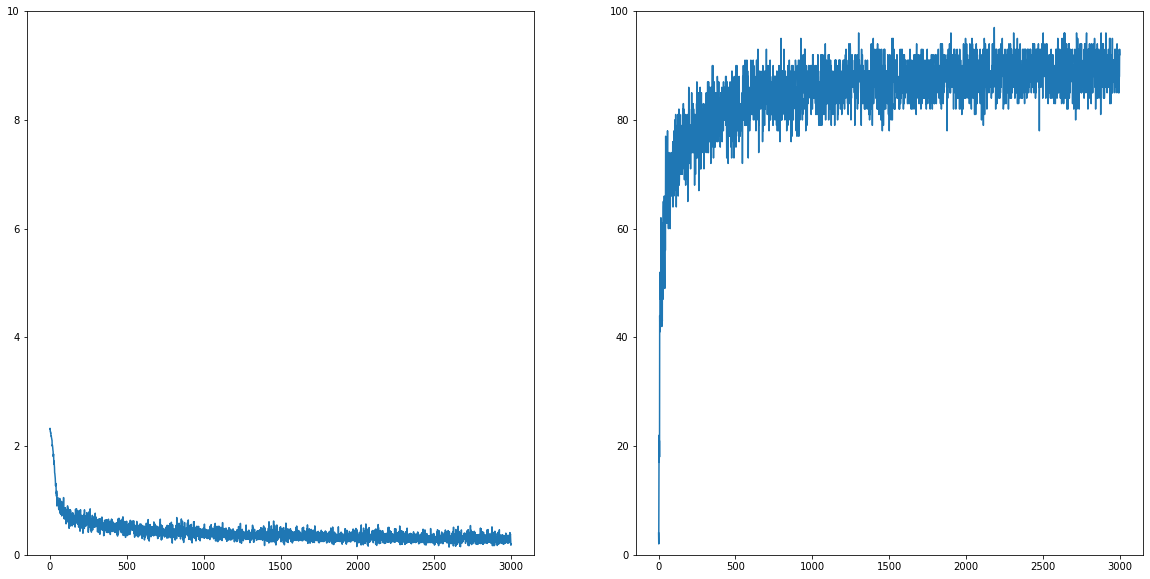

In [127]:
from matplotlib import pylab as plt
import numpy as np
plt.figure(figsize=(20,10))
plt.subplot(121), plt.plot(np.arange(len(train_cost)), train_cost), plt.ylim([0,10])
plt.subplot(122), plt.plot(np.arange(len(train_accu)), 100 * torch.as_tensor(train_accu).numpy()), plt.ylim([0,100])

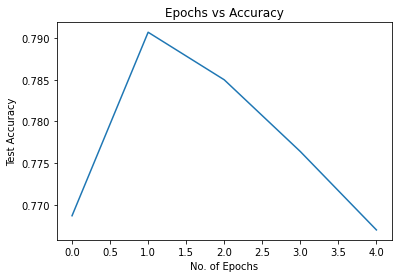

In [128]:
plt.plot(range(training_epochs), test_accu)
plt.xlabel("No. of Epochs")
plt.ylabel("Test Accuracy")
plt.title("Epochs vs Accuracy")
plt.show()

In [129]:
# Test model and check accuracy
model.eval()    # set the model to evaluation mode (dropout=False)

X_test = Variable(test_set.data.view(len(test_set), 1, 28, 28).float())
Y_test = Variable(test_set.targets)

prediction = model(X_test)

# Compute accuracy
correct_prediction = (torch.max(prediction.data, dim=1)[1] == Y_test.data)
accuracy = correct_prediction.float().mean().item()
print('\nAccuracy: {:2.2f} %'.format(accuracy*100))


Accuracy: 76.70 %


In [130]:
model_comparision['CNN6']=int(sum(test_accu*100) / len(test_accu))

In [131]:
output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }

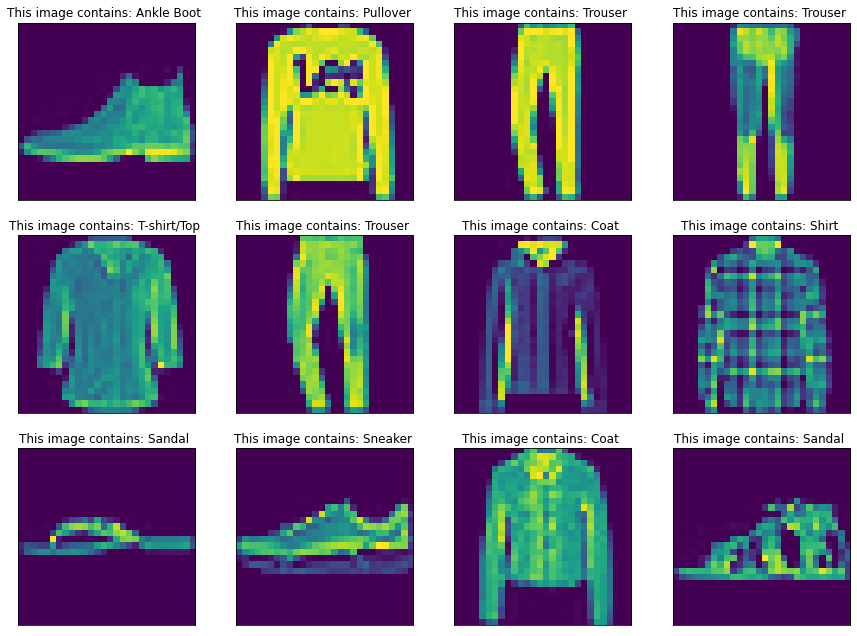

In [132]:
from matplotlib import pylab as plt

plt.figure(figsize=(15,15), facecolor='white')

for i in range(0,12):
  val, idx = torch.max(prediction, dim=1)
  plt.subplot(4,4,i+1)  
  plt.imshow(X_test[i][0])
  plt.title('This image contains: {0:>2} '.format(output_mapping[idx[i].item()]))

  plt.xticks([]), plt.yticks([])
  plt.plt.subplots_adjust()

## Third Conv2d Model

### Hyperparameter for this model are add BatchNormalization with different Learning rates and no of epochs

#### Add BatchNormalization with Learning rate 0.001 and 5 epochs


In [133]:
class CNN7(nn.Module):
    
    def __init__(self):
        super(CNN7, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        
        self.fc1 = nn.Linear(in_features=64*1*1, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [134]:
model = CNN7()
model.to(device)

error = nn.CrossEntropyLoss()


learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

CNN7(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (fc1): Linear(in_features=64, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
 

In [135]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5094646215438843, Accuracy: 83.91999816894531%
Iteration: 1000, Loss: 0.4835793972015381, Accuracy: 86.2699966430664%
Iteration: 1500, Loss: 0.277226060628891, Accuracy: 86.51000213623047%
Iteration: 2000, Loss: 0.31000420451164246, Accuracy: 87.22000122070312%
Iteration: 2500, Loss: 0.17602261900901794, Accuracy: 86.98999786376953%
Iteration: 3000, Loss: 0.19672556221485138, Accuracy: 86.61000061035156%


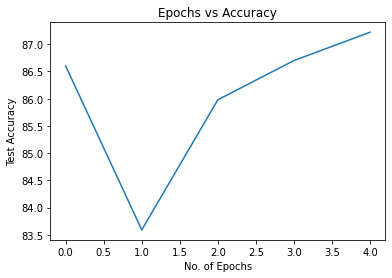

In [136]:
plt.plot(range(num_epochs), random.sample(accuracy_list, num_epochs))
plt.xlabel("No. of Epochs")
plt.ylabel("Test Accuracy")
plt.title("Epochs vs Accuracy")
plt.show()

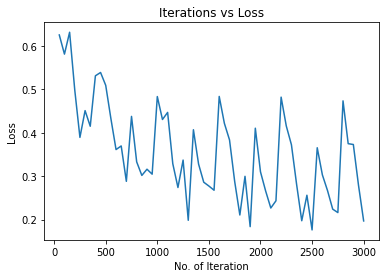

In [137]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

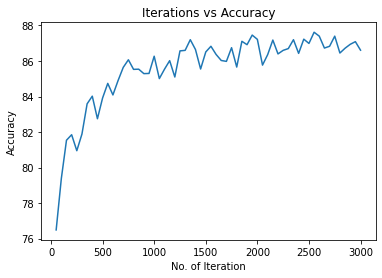

In [138]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [139]:
model_comparision['CNN7']=int(sum(accuracy_list) / len(accuracy_list))

#### Add BatchNormalization with Learning rate 0.001 and 8 epochs


In [140]:
class CNN8(nn.Module):
    
    def __init__(self):
        super(CNN8, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        
        self.fc1 = nn.Linear(in_features=64*1*1, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [141]:
model = CNN8()
model.to(device)

error = nn.CrossEntropyLoss()


learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

CNN8(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (fc1): Linear(in_features=64, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
 

In [142]:
num_epochs = 8
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5974496603012085, Accuracy: 84.26000213623047%
Iteration: 1000, Loss: 0.43313130736351013, Accuracy: 85.55999755859375%
Iteration: 1500, Loss: 0.3117195665836334, Accuracy: 84.9800033569336%
Iteration: 2000, Loss: 0.3147669732570648, Accuracy: 86.69999694824219%
Iteration: 2500, Loss: 0.15075619518756866, Accuracy: 87.19000244140625%
Iteration: 3000, Loss: 0.21219384670257568, Accuracy: 86.30000305175781%
Iteration: 3500, Loss: 0.2891448736190796, Accuracy: 86.9000015258789%
Iteration: 4000, Loss: 0.27316248416900635, Accuracy: 87.37000274658203%
Iteration: 4500, Loss: 0.17566213011741638, Accuracy: 86.45999908447266%


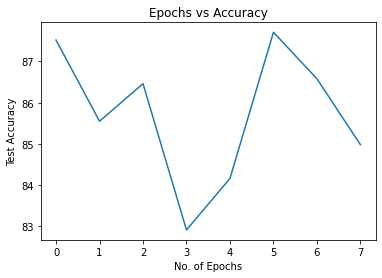

In [143]:
plt.plot(range(num_epochs), random.sample(accuracy_list, num_epochs))
plt.xlabel("No. of Epochs")
plt.ylabel("Test Accuracy")
plt.title("Epochs vs Accuracy")
plt.show()

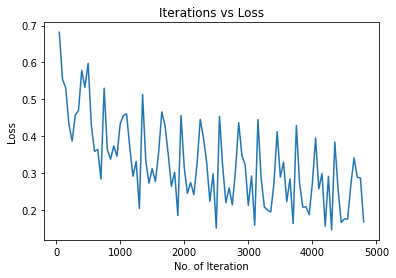

In [144]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

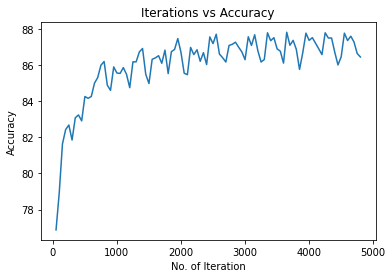

In [145]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [146]:
model_comparision['CNN8']=int(sum(accuracy_list) / len(accuracy_list))

#### Add BatchNormalization with Learning rate 0.001 and 10 epochs


In [147]:
### Second Model

In [148]:
class CNN9(nn.Module):
    
    def __init__(self):
        super(CNN9, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        
        self.fc1 = nn.Linear(in_features=64*1*1, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

### Making a model of our CNN class

*   Creating a object(model in the code)
*   Transfering it into GPU if available.
*  Defining a Loss function. we're using CrossEntropyLoss() here.
*  Using Adam algorithm for optimization purpose.



In [149]:
model = CNN9()
model.to(device)

error = nn.CrossEntropyLoss()


learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

CNN9(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (fc1): Linear(in_features=64, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
 

## Training a network and Testing it on test dataset

In [150]:
num_epochs = 10
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.531943678855896, Accuracy: 84.51000213623047%
Iteration: 1000, Loss: 0.3717266917228699, Accuracy: 85.66000366210938%
Iteration: 1500, Loss: 0.29708433151245117, Accuracy: 85.26000213623047%
Iteration: 2000, Loss: 0.29851019382476807, Accuracy: 86.70999908447266%
Iteration: 2500, Loss: 0.1678154170513153, Accuracy: 86.19000244140625%
Iteration: 3000, Loss: 0.2104906141757965, Accuracy: 85.83000183105469%
Iteration: 3500, Loss: 0.3407498300075531, Accuracy: 87.26000213623047%
Iteration: 4000, Loss: 0.32819226384162903, Accuracy: 87.11000061035156%
Iteration: 4500, Loss: 0.18806035816669464, Accuracy: 87.02999877929688%
Iteration: 5000, Loss: 0.30280548334121704, Accuracy: 86.72000122070312%
Iteration: 5500, Loss: 0.13391141593456268, Accuracy: 86.52999877929688%
Iteration: 6000, Loss: 0.1635657250881195, Accuracy: 85.91999816894531%


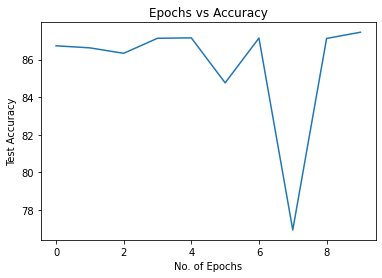

In [151]:
plt.plot(range(num_epochs), random.sample(accuracy_list, num_epochs))
plt.xlabel("No. of Epochs")
plt.ylabel("Test Accuracy")
plt.title("Epochs vs Accuracy")
plt.show()

### Visualizing the Loss and Accuracy with Iterations


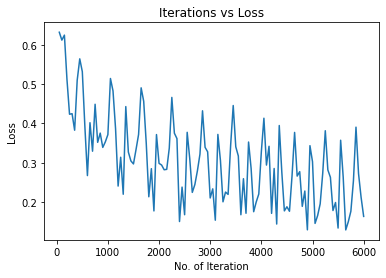

In [152]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

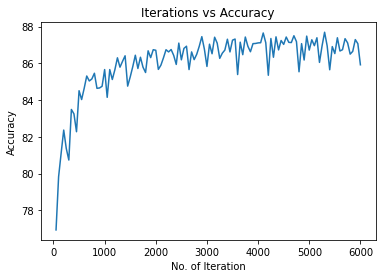

In [153]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [154]:
model_comparision['CNN9']=int(sum(accuracy_list) / len(accuracy_list))

### Looking the Accuracy in each class of FashionMNIST dataset

In [155]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 87.90%
Accuracy of Trouser: 97.00%
Accuracy of Pullover: 69.10%
Accuracy of Dress: 85.80%
Accuracy of Coat: 61.30%
Accuracy of Sandal: 96.10%
Accuracy of Shirt: 73.40%
Accuracy of Sneaker: 94.60%
Accuracy of Bag: 97.60%
Accuracy of Ankle Boot: 95.90%


### Printing the Confusion Matrix 

In [156]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [157]:
# show the confusion metrics to show the each class of fashion with there respective score, recall and precision.
import sklearn.metrics as metrics

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.81      0.81      0.81    120000
           1       0.97      0.97      0.97    120000
           2       0.77      0.81      0.79    120000
           3       0.88      0.86      0.87    120000
           4       0.78      0.77      0.77    120000
           5       0.95      0.95      0.95    120000
           6       0.62      0.61      0.62    120000
           7       0.92      0.92      0.92    120000
           8       0.96      0.96      0.96    120000
           9       0.94      0.95      0.94    120000

    accuracy                           0.86   1200000
   macro avg       0.86      0.86      0.86   1200000
weighted avg       0.86      0.86      0.86   1200000




## Resnet50 Model

In [158]:
import math
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sklearn
import matplotlib.pyplot as plt
import itertools




torch.set_printoptions(linewidth=120)

# Performing the ETL Process 

data_set = torchvision.datasets.FashionMNIST(
     root = './data/FashionMNIST'
     ,train=True
    ,download=True
    ,transform=transforms.Compose([
      transforms.ToTensor()
    ])
)

train_set, test_set = torch.utils.data.random_split(data_set, [50000, 10000])

batch_size = 500
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)


class FashionMNISTResNet(nn.Module):
    def __init__(self, in_channels=1):
        super(FashionMNISTResNet, self).__init__()
        # loading a pretrained model
        self.model = torchvision.models.resnet50(pretrained=True)
        # changing the input color channels to 1 since original resnet has 3 channels for RGB
        self.model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        #change the output layer to 10 ckasses as the original resnet has 1000 classes
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 10)

    def forward(self, t):       
        return self.model(t)
    

def get_num_correct_predictions(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [159]:
from tqdm import tqdm

In [160]:
lr_list = [0.001]
lr = 0.001
acc = []
test_acc=[]
fin_acc = []
fin_test_acc=[]
ep = []

network = FashionMNISTResNet()
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)

for lr in (lr_list):

        network = FashionMNISTResNet()

        optimizer = optim.Adam(network.parameters(), lr=lr)
    
        for epoch in (range(8)):
        
            total_loss = 0
            total_correct = 0
            total_test_loss = 0
            total_test_correct = 0
            ep.append(epoch)
            for batch in tqdm(train_loader):
                images, labels = batch 
                preds = network(images) 
                loss = F.cross_entropy(preds, labels)
                optimizer.zero_grad()
                loss.backward() 
                optimizer.step()

                total_loss += loss.item() * batch_size 
                total_correct += get_num_correct_predictions(preds, labels)
        
            for test_batch in tqdm(test_loader):
                test_images, test_labels = test_batch
                test_preds = network(test_images)
        
                total_test_correct += get_num_correct_predictions(test_preds, test_labels)

            accuracy = total_correct / len(train_set) * 100
            acc.append(accuracy)
            test_accuracy = total_test_correct / len(test_set) * 100
            test_acc.append(test_accuracy)
            print("epoch:", epoch, "total_correct:", total_correct, "loss:", total_loss, "Training Accuracy:", accuracy,'%', "Test Accuracy:", test_accuracy,'%')
        fin_acc.append(accuracy)
        fin_test_acc.append(test_accuracy)
        print("Learning_rate:", lr, "Accuracy:", accuracy)


/mnt/dsc-nfs-1/nadeem/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/dsc-nfs-1/nadeem/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 20/20 [00:16<00:00,  1.25it/s]


epoch: 0 total_correct: 40795 loss: 25280.42061626911 Training Accuracy: 81.58999999999999 % Test Accuracy: 86.69 %


100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


epoch: 1 total_correct: 44440 loss: 15001.938536763191 Training Accuracy: 88.88000000000001 % Test Accuracy: 89.29 %


100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


epoch: 2 total_correct: 45250 loss: 12631.115965545177 Training Accuracy: 90.5 % Test Accuracy: 90.36 %


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


epoch: 3 total_correct: 45992 loss: 10859.902366995811 Training Accuracy: 91.984 % Test Accuracy: 90.58 %


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


epoch: 4 total_correct: 46440 loss: 9644.787922501564 Training Accuracy: 92.88 % Test Accuracy: 90.56 %


100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


epoch: 5 total_correct: 46917 loss: 8230.813581496477 Training Accuracy: 93.83399999999999 % Test Accuracy: 90.53999999999999 %


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


epoch: 6 total_correct: 47088 loss: 7907.4572287499905 Training Accuracy: 94.176 % Test Accuracy: 91.39 %


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]

epoch: 7 total_correct: 47444 loss: 6789.532545953989 Training Accuracy: 94.88799999999999 % Test Accuracy: 90.91 %
Learning_rate: 0.001 Accuracy: 94.88799999999999


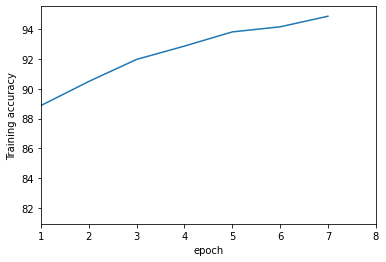

In [161]:
plt.plot(ep, acc)
plt.xlim((1,8))
plt.xlabel("epoch")
plt.ylabel("Training accuracy")
plt.show()
     

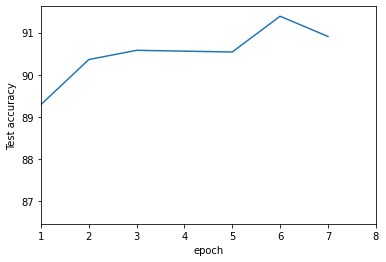

In [162]:
plt.plot(ep, test_acc)
plt.xlim((1,8))
plt.xlabel("epoch")
plt.ylabel("Test accuracy")
plt.show()

In [163]:
model_comparision['Resnet50']=int(sum(acc) / len(acc))

In [164]:
model_comparision

{'CNN1': 83,
 'CNN2': 88,
 'CNN3': 84,
 'CNN4': 80,
 'CNN5': 76,
 'CNN6': 77,
 'CNN7': 85,
 'CNN8': 86,
 'CNN9': 86,
 'Resnet50': 91}

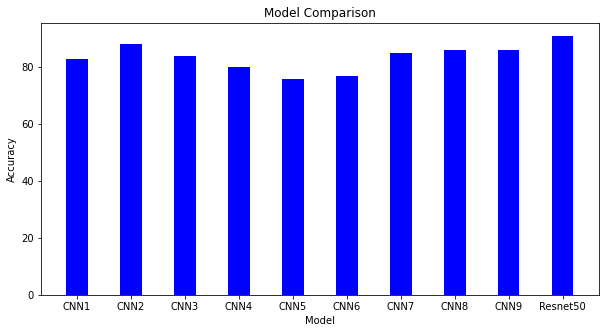

In [165]:
model = list(model_comparision.keys())
accuracy = list(model_comparision.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(model, accuracy, color ='blue',
        width = 0.4)
 
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.show()

## Conclusion
From the above barchart show result about the each model. In first model which is very simple model has only conv2d and fully connected layers it show that it perform best in which we choose as learning rate 0.001 and when choose 0.0001 and 0.01 it less accurate this shown taht learning rate play very crucial role in deep learing.
In second model where we add maxpool and dropout layers as we know both reduce the complexity of the model and so model perform little bit bad. And also checked that when batched size increased for less complex model them model aslo perform bad. In the third model we used a combination of learning rate, epochs and aslo add batchnormilization layers into it. As earlier we have seen that at 0.001 learning rate it perform best so here also when we used 0.001 as learning rate it perform better than other teo models. As we conclude that learing rate it the most import parameter in these models after that batchnormalization and epochs as well.In the last model is pretrained resnet50 perform best of all other models.Because it is the most complex model all of the above and also have pretrained weights.